In [78]:
import numpy as np
import matplotlib.pyplot as plt
from hdf5manager import hdf5manager as h5
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import scipy
from pandas import pandas as pd
from pandas import DataFrame
from skimage.measure import label, regionprops
from scipy.ndimage.filters import gaussian_filter, convolve
from skimage.morphology import disk, watershed
from skimage.morphology import erosion, dilation, opening, closing
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage.filters import maximum_filter
from opticFlow import opticFlow as of
import colorsys
import wholeBrain as wb
from waveletAnalysis import waveletAnalysis as wave
import cv2

In [79]:
path = '/Users/jcrndm/Documents/test_angs_mags.hdf5'

h = h5(path)
h.keys()
print(dir(h))

mov = h.load('mags')
angs = h.load('rot_angs')
start_stop = h.load('start_stop_index')
dfof = h.load('dfof')


print(start_stop)
print(h.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'close', 'keys', 'load', 'open', 'path', 'print', 'save', 'verbose']
(1000, 5000)
['start_stop_index', 'dfof', 'mags', 'rot_angs']


In [ ]:
# path2 = '/Users/jcrndm/Downloads/brain_data.hdf5'

# k = h5(path2)
# k.keys()
# dfof = k.load('dfof_mean')
# h.save({'dfof':dfof})

# plt.plot(dfof)

In [ ]:
print(mov.shape)
mean = np.mean(mov, axis = (1,2))
fig, axis = plt.subplots(2, figsize = (10,6), sharex = True)

time = np.arange(dfof.shape[0])/10
time2 = np.arange(mean.shape[0])/30

axis[0].plot(time2, mean, color='k')
axis[0].set_ylabel('Magnitude')
axis[0].set_title ('Movement')

axis[1].plot(time, dfof, color='g')
axis[1].set_ylabel('dfof')
axis[1].set_xlabel('time(s)')
axis[1].set_title('Brain activity')

plt.savefig('/Users/jcrndm/Documents/SIP2019/Brain_Movement.png')


In [ ]:
mean = np.mean(mov, axis = (1,2))
fig, axis = plt.subplots(2, figsize = (10,6), sharex = True)

time = np.arange(dfof.shape[0])/10
time2 = np.arange(mean.shape[0])/30

axis[0].plot(time2, mean, color='k')
axis[0].set_ylabel('Magnitude')
axis[0].set_title ('Movement')

axis[1].plot(time, dfof, color='g')
axis[1].set_ylabel('dfof')
axis[1].set_xlabel('time(s)')
axis[1].set_title('Brain activity')

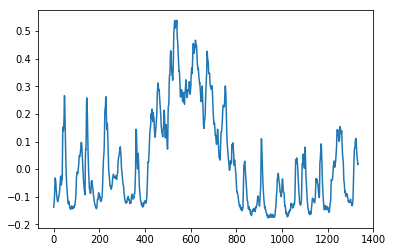

<Figure size 432x288 with 0 Axes>

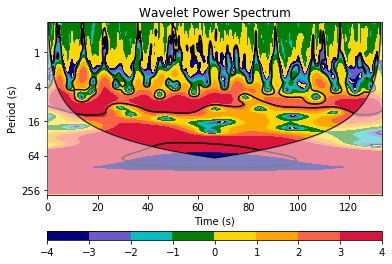

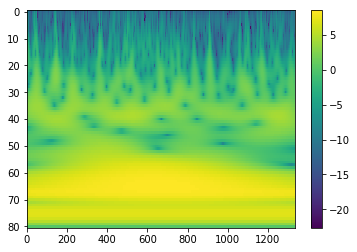

(81, 1334)


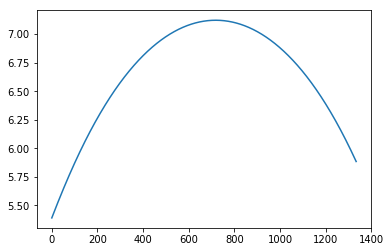

In [80]:
plt.plot(dfof)
plt.show()

w = wave(dfof, fps=10)
w.plotPower()
plt.show()

plt.imshow(np.log2(w.power), aspect = 'auto')
plt.colorbar()
plt.show()

print(w.power.shape)

plt.plot(np.log2(w.power)[70,:])
plt.show()

In [ ]:
wb.playMovie(mov)

In [ ]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(mov[431], aspect = "auto") 
axs[0].axis("off")
axs[1].imshow(mov[434], aspect = "auto", cmap = "cubehelix") 
axs[1].axis("off")


In [ ]:
plt.imshow(mov[430])
plt.colorbar()

In [ ]:
# Frame testing

def localMaxima2d(array_2d):
    # finds local maxima of a given 2d array
    neighborhood = np.ones((5,5))
    local_max = maximum_filter(array_2d, footprint=neighborhood)==array_2d
    background = (array_2d==0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    lmax = local_max ^ eroded_background
    return lmax

frames = [431, 433, 1436, 1580]

fig, axs = plt.subplots(len(frames), 2, figsize=(20,10))
for i, frame in enumerate(frames):
    f = mov[frame]
    fmax = localMaxima2d(f)
    fmaxl = label(fmax)
    axs[i,0].set_title('Frame {}'.format(frame))
    axs[i,0].imshow(f)
    mask = f.copy() * 0
    mask[f>0]=1
    wshed = watershed(-f, fmaxl, mask=mask)
    nfmax = fmaxl.max()
    percent = f.copy()
    x = []
    y = []
    u = []
    v = []
    for region in regionprops(fmaxl):
        x.append(region.coords[0][1])
        y.append(region.coords[0][0]) 
    for region in np.arange(1,nfmax+1,1):
        regionmean = np.sum(f[wshed==region])
        percent[wshed==region]/=regionmean
        percent[wshed==region]*=angs[frame, wshed==region]
        angle = np.sum(percent[wshed==region])
        u.append(np.cos(angle))
        v.append(np.sin(angle))
    print(x)
    print(y)
    print(u+x)
    print(u+v)
    axs[i,0].quiver(x,y,u,v, angles='xy', scale_units='xy', scale = 1)
    axs[i,1].imshow(percent)
    axs[i,0].axis('off')    
    axs[i,1].axis('off')
# plt.tight_layout()
plt.show()

In [ ]:
#  means including zeros in frame, sends to list
def findMeans(three_d_array):
    all_means = []
    for i, frame in enumerate(three_d_array):
        all_means.append(np.mean(frame))
    x = range(len(all_means))
                         
    plt.scatter(all_means, x)
    return all_means

        
mean_outputs =findMeans(mov)

In [ ]:
# standard deviation with zeros 
def standardDeviation(array_3d):
    all_deviations = []
    x = []
    for i, frame in enumerate(array_3d):
        mean = np.mean(frame)
        x.append(i)
        deviations = []
        for r in frame:
            for c in range(len(r)):
                deviations.append(((r[c]) - mean) ** 2)
        mean1 = np.mean(deviations)
        current_deviation = mean1 ** (1/2)
        all_deviations.append(current_deviation)
    plt.scatter(x, all_deviations) 
    return all_deviations

set_dev = standardDeviation(mov)
print(set_dev)

In [ ]:
# Average magnitude in multiple dimensions
def motionCharacterize(array3d):
    brain_magnitude = np.zeros(array3d.shape[0])
    for n, frame in enumerate(array3d):
        brain_magnitude[n] = np.mean(frame)

    win_size = 10
    mag_mean = np.convolve(brain_magnitude, np.ones(win_size)/win_size, mode = 'same')

    threshold = np.zeros(mag_mean.shape)
    threshold[mag_mean > 0] = 1 
    frame_ind = np.where(threshold == 1)

    start = []
    end = []
    for i, frame in enumerate(frame_ind[0]):
        if i == 0:
            start.append(frame)
        elif len(frame_ind[0])-1 == i:   
            end.append(frame)
        elif (frame + 1) != (frame_ind[0][i + 1]):
            end.append(frame)
            start.append(frame_ind[0][i + 1])
#     print(start)
#     print(end)
#     Duration of event frames in seconds
    event_frames = (np.array(end) - np.array(start))/30
    mag_per_event = np.zeros(array3d.shape[0])
    duration = np.zeros(array3d.shape[0])
    rest = np.zeros_like(duration)

    for i, st in enumerate(start):
        if i == 0:        
            rest[:st] = st
            rest[end[i]:start[i+1]] = start[i+1] - end[i]
        elif i == len(start)-1:
            rest[end[i]:] = rest.shape[0] - end[i]
        else:
            rest[end[i]:start[i+1]] = start[i+1] - end[i]
        mag_per_event[st:end[i]] = np.sum(array3d[st:end[i]])/event_frames[i]
        duration[st:end[i]] = event_frames[i]
        
    print(duration)
    print(rest)
# #     Duration intervals
#     frame_durations = []
#     for i in range(len(start)):
#         interval = end[i] - start[i]
#         frame_durations.append(interval)
#     print(frame_durations)
    
    #   Magnitude events
#     fig = plt.figure(figsize = (10,5))
#     plt.plot(brain_magnitude, color='k')
#     plt.plot(mag_mean,color='g')
#     plt.plot(threshold,color='r')
#     plt.ylim([0,2])
#     plt.show()
#     plt.plot(mag_per_event)
#     plt.show()

#     print(frame_durations[1])
#     for i in frame_durations:
#     print(dfDur)

    
    return mag_per_event, duration, rest
dfDur = pd.DataFrame()

dfDur['mag_per_event'], dfDur['duration'], dfDur['rest']= motionCharacterize(mov)
# mag_data = motionCharacterize(mov)
# plt.plot(dfDur['mag_per_event'])



fig = plt.figure(figsize=(10,5))
plt.plot(dfDur['duration'] * 100, label='duration')
plt.plot(dfDur['rest'], label='rest')
plt.legend()
plt.xlabel("Frames")
plt.ylabel("Intervals")
plt.show()

In [ ]:
der = np.zeros_like(dfof)*10
# Brain Activity Boundaries
for i, val in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = val - dfof[i-1]
der *= 10

d_switch = []
u_switch = []

# Derivative of the graph by points 
for i, val in enumerate(der):
    if i == 0 or i == der.shape[0]:
        continue
    elif (val > 0) and (der[i-1] < 0):
        u_switch.append(i)
    elif (val < 0) and (der[i-1] > 0):
        d_switch.append(i)
        
u_switch = np.array(u_switch)/10
d_switch = np.array(d_switch)/10
  
time = np.arange(dfof.shape[0])/10

fig, axis = plt.subplots(1,figsize = (20,5))

# Line-Scatter Graph
plt.scatter(time[der<0], der[der<0], linewidths =0.005)
plt.scatter(time[der>0], der[der>0])
plt.plot(time, dfof, color = 'k')
for line in u_switch:
    plt.axvline(x = line, color='g')
for line in d_switch:
    plt.axvline(line, color='r')
plt.xlim([0,134])
plt.show()

In [ ]:
# # Data frame practice

# dict = {'col1': [1, 2], 'col2': [3, 4]}
# data_f = pd.DataFrame(data = dict)
# print (data_f)
# print(data_f.dtypes)

# data_f2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]), columns = ['a', 'b', 'c'])
# print(data_f2)

# my_data = pd.DataFrame(np.array([['Hello','Hola', '你好'],['Bye', 'Adios', '再见']]), columns = ['English', 'Spanish', 'Chinese'], index = ["Hi's","Bye's"])
# print(my_data)

In [ ]:
# df = pd.DataFrame({'Std': [1, 2, 3, 4, 5], 'Min': [6, 7, 8, 9, 10], 'Max': [11, 12, 13, 14, 15]})
# new_level = 'Numbers'
# # df.columns = [new_level, df.columns]
# df

# # _______________________________________________________________________________________________________________________

# data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# # Create the pandas DataFrame 
# df2 = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# # print dataframe. 
# df2

In [ ]:
# # mode of the magnitudes
# def mag_mode(array3d):
# #     print(array3d)
#     void = np.zeros(array3d.shape[0])
    
#     print(void[0])
#     for i, n in enumerate(array3d.shape):
# #         print(n)
# #         print (array3d[i])
#         if i == 0:
#             continue
#         elif n == void[i]:
#             poss_mode = [n]
#             if np.where(array3d[i] == 1):
#                 poss_mode.append(n)
#             else:
#                 continue
#         else: 
#             poss_mode2 = [n]
# #             if void[i] not in poss_mode2:
            
# #     print(poss_mode) 
# mag_mode(mov)

In [ ]:
print(dfof)
fig = plt.figure(figsize=(10, 7))
plt.plot(dfof)
plt.show

In [ ]:
#print (mov.shape)
print ("Displays the dips in the graph, using derivatives")
print ("The graph is the original brain data and derivation line, but from [0, 150] and draws lines of either green(increasing) or red(decreasing)" + 
       "depending on the point of the graph. ")

der = np.zeros_like(dfof)*10
# Brain Activity Boundaries
for i, val in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = val - dfof[i-1]
der *= 10

d_switch = []
u_switch = []

# Derivative of the graph by points
for i, val in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    elif (val > 0) and (dfof[i-1] < 0):
        u_switch.append(i)
    elif (val < 0) and (dfof[i-1] > 0):
        d_switch.append(i)

u_switch = np.array(u_switch)/10
d_switch = np.array(d_switch)/10

time = np.arange(der.shape[0])/10

fig, axis = plt.subplots(1, figsize = (20, 5))
time = np.arange(der.shape[0])/10

for i, j in enumerate(dfof):
    if i == 0 or i == dfof.shape[0]:
        continue
    else:
        der[i] = j - dfof[i-1]
plt.plot(der/.1)
plt.xlim([0, 400])
plt.plot(dfof)

#plt.plot(time, der/.1, color = 'k')
for line in u_switch:
    go_up = plt.axvline(x = line, color='g')
for line in d_switch:
    go_down = plt.axvline(line, color='r')
plt.xlim([0,150])
plt.show() 

In [61]:
def total_magnitude(array3d):
    total = np.sum(array3d)
    
    return total
total_magnitude(mov)


# # Area of Motion
# def surface_area(array3d):
#     area_count = []
#     for i in array3d:
#         count = 0
#         for r in i:
#             for c in r:
#                 if c > 0:
#                     count += 1
                    
#         area_count.append(count)
        
#     return area_count
    
# surface_area(mov)

# # Area of Brain Activity
# def surface_area_b(array2d):
#     area_count = []
#     for i, c in enumerate(array2d):
#         count = 0
#         if c != 0:
#             count += c
                    
#         area_count.append(count)
        
#     return area_count
    
# surface_area_b(dfof)

5754458.419108027

In [ ]:
# Percentage of the brain in active state/event 
def brainUseSpan(array3d):
    percent_list = []
    
    for i in surface_area(array3d):
        percent_list.append((i / total_magnitude(array3d)) * 100)
        
    new_percent_list = np.around(percent_list, 3)
    return new_percent_list
    
brainUseSpan(mov)    

In [ ]:
# Percent of the magnitude @ every frame 
def motion_percentage(array2d):
    points = []
    percent_list = []
    array2d -= np.min(array2d)
    total = np.sum(array2d)
    
    for i in array2d:
        if len(points) < 10:
            points.append(i)
        elif len(points) == 10:
            for i in np.arange(10):
                percent_list.append(np.sum(points))
        else:
            points = []
       
    rounded_list = np.around(((percent_list/total) * 100), 3)
    
    return rounded_list
    
motion_percentage(dfof)

In [ ]:
# Frames that aren't transitioning, but consistent over a certain amount of time
def time_continuity(timecourse, forward_or_backward='forward'):
    continuous_limit = []
    difference_continuous = 0
    
    if forward_or_backward == 'forward':
        print("Calculating forward continuance")
    elif forward_or_backward == 'backward':
        print("Calculating backward continuance")
        timecourse = timecourse[::-1]
    
    
    for i in timecourse:
        if i == 0:
            difference_continuous += 1
            continuous_limit.append(difference_continuous)
        else:
            difference_continuous = 0
            continuous_limit.append(difference_continuous)
            
            
    if forward_or_backward == 'backward':
        print("Calculating backward continuance")
        continuous_limit = continuous_limit[::-1]
    
    return continuous_limit

# forward = count up, backward = count down   
fig = plt.figure(figsize = (14,7))
plt.plot(time_continuity(dfDur['duration'], forward_or_backward 
time_continuity(dfDur['duration'], forward_or_backward = 'forward')
= 'backward'), label = "Backward")
plt.plot(time_continuity(dfDur['duration'], forward_or_backward = 'forward'), label = "Forward")
plt.legend()

In [ ]:
def find_error(array3d):
    minimum = np.min(array3d)
    exact = np.sum(array3d)/len(array3d)
    error_list = []
    percent_error_list = []
    error_value = 0
    
    for array in array3d:
        for lst in array:
            for i in lst:
                if i == 0:
                    error_list.append(error_value)
                    continue
                elif i > 0:
                    if i == i - 1:
                        error_list.append(error_value)
#                     elif i != i - 1:
#                         error_list.append(i - min)
#                 elif i < 0:
    
    for i in error_list:
        percent_error_list.append(i/exact) 
    
    return percent_error_list
    
find_error(findMeans(mov))

In [ ]:
def percent_error(array3d):
    surface_areas = surface_area(array3d)
    percent_error_list = []
    for i in range(len(array3d)):
        percent_error_list.append((surface_areas[i]/(105 * 141)) * 100)
    return percent_error_list
    
    
#     set_of_size = []
    
#     for i in range(len(array3d)):
#         set_of_size.append(np.size(array3d))
#     print(surface_area(array3d))
#     print(set_of_size)
#     for i in set_of_size:
#         error = surface_area(array3d) / i 
#         percent_error_list.append(error * 100)

 #   return percent_error_list    
print(percent_error(mov))

In [ ]:
def standard_deviation_y(array3d):
#     print(array3d.shape[2])
#     print(standardDeviation(array3d))
    deviations = []
    for i in range(len(array3d)):
        sums = []
        for r in array3d[i]:
            temp = 0
            for c in r:
                if c != 0:
                    temp += c
            sums.append(temp)
        deviations.append(np.std(sums))
    return np.around(deviations, 3)
standard_deviation_y(mov)